# Movie Variability

In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
from bioinfokit.analys import stat

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from pingouin import ancova

In [3]:
D = lambda x,y: ((x-y)**2).sum(axis=1)

In [4]:
def get_log_ax(orient="v"):
    if orient == "v":
        figsize = (7, 6)
        set_scale = "set_yscale"
    else:
        figsize = (10, 8)
        set_scale = "set_xscale"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.patch.set_alpha(1)
#     getattr(ax, set_scale)("log")
    return ax

## Description

Compute subset groups of gradients and see how stable the extracted gradients are for each movies. 

GOAL: Evaluate "stability" across subsamples of subjects-generated gradients

## Table of Contents
- [Movie Variability](#stable)

In [5]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

## Intersubject variability Fullmovie vs Rest

### Compute stats difference of subjects variability in Fullmovies versus Rest

In [16]:
total_series = load('./data/fmri_414_series.pkl')
if 'Rest' in total_series:
    del total_series['Rest']

subjects = total_series[next(iter(total_series))]
all_dists = {sub:  {} for sub in subjects}
all_grads = {sub:  {} for sub in subjects}

for mname in total_series:
    for _id in subjects:
        tmp_series = total_series[mname][_id]
        fc = FC(tmp_series)
        g = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
        g.fit(fc)
        grad = g.gradients_
        
        fscore = D(grad.mean(axis=0),grad)
        all_grads[_id][mname] = grad
        all_dists[_id][mname] = fscore

In [55]:
indiv_std = []
for _id in subjects:
    indiv_std.append(np.asarray(list(all_dists[_id].values())).std(axis=0))
    
indiv_std = np.asarray(indiv_std)

# remove outliers
perc = 95 # percentile removal
indiv_std[indiv_std >= np.percentile(indiv_std.flatten(), perc)] = 0

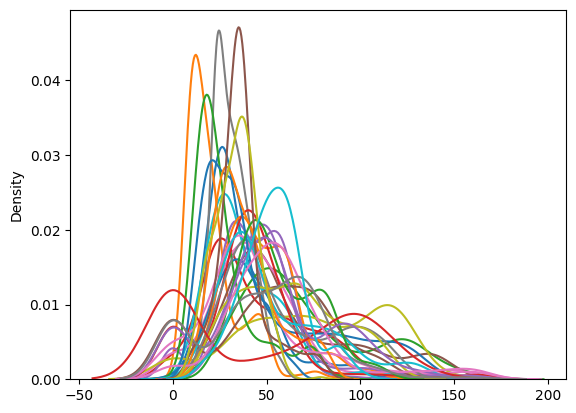

In [56]:
for i in range(len(subjects)):
    sns.kdeplot(indiv_std[i])

#### ANOVA movie variance for each subjects

In [50]:
# Performing two-way ANOVA
networks = list(index2region)

df = {"score": [], "cond": [], 'network': []}
for n in networks:
    for nb_id in range(indiv_std.shape[0]):
        df['score'] += list(indiv_std[nb_id][index2region[n]])
        df['cond']  += [str(nb_id)] * len(index2region[n])
        df['network'] += [n] * len(index2region[n])
    
df = pd.DataFrame.from_dict(df)

model = ols('score ~ C(cond) + C(network) + C(cond):C(network)',data=df).fit()
result = sm.stats.anova_lm(model, type=2)

In [52]:
print(result)

                         df        sum_sq        mean_sq           F  PR(>F)
C(cond)                29.0  8.201951e+06  282825.882691  208.986025     0.0
C(network)              7.0  3.050481e+06  435782.943086  322.009231     0.0
C(cond):C(network)    203.0  7.963114e+06   39227.162854   28.985780     0.0
Residual            12180.0  1.648349e+07    1353.324380         NaN     NaN
